# Download Celeba Dataset

In [1]:
celeba_path = "https://drive.google.com/open?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM"

In [2]:
!pip install gdown

In [1]:
import zipfile

with zipfile.ZipFile('/home/jovyan/video-storage/amit_files/MTP_01/img_align_celeba.zip', 'r') as zip_ref:
    zip_ref.extractall('destination_folder')


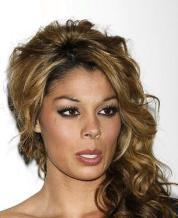

In [9]:
import os
from PIL import Image
path = "/home/jovyan/video-storage/amit_files/MTP_01/celeba_dataset/img_align_celeba"

folder = os.listdir(path)
img = Image.open(path + '/' + folder[5])
img

# Download Triplet dataset (for temporal frame interpolation):

In [1]:
import requests
import os

In [2]:
# Lanczos resampling

In [ ]:

# URL of the zip file
url = "http://data.csail.mit.edu/tofu/dataset/vimeo_triplet.zip"
destination = "/home/jovyan/video-storage/amit_files/MTP_01/triplet_dataset.zip"


In [ ]:

def download_file(url, destination):
    # Send a GET request to the URL
    response = requests.get(url, stream=True)

    # Raise an error if the request was unsuccessful
    response.raise_for_status()

    # Get the total file size from the headers
    total_size = int(response.headers.get('content-length', 0))

    # Create a destination directory if it doesn't exist
    os.makedirs(os.path.dirname(destination), exist_ok=True)

    # Open the destination file in binary write mode
    with open(destination, 'wb') as file:
        # Download the file in chunks
        for data in response.iter_content(chunk_size=8192):
            file.write(data)
            # Print progress
            if total_size > 0:
                downloaded_size = file.tell()
                print(f'Downloaded {downloaded_size / total_size:.2%}', end='\r')

    print("\nDownload completed!")

In [ ]:
# download_file(url, destination)

In [ ]:

def extract_zip(zip_path, extract_to):
    # Ensure the extraction folder exists
    os.makedirs(extract_to, exist_ok=True)

    # Open the .zip file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Extract all contents into the specified folder
        zip_ref.extractall(extract_to)
        print(f"Extracted {zip_path} to {extract_to}")


In [ ]:
extract_to = "/home/jovyan/video-storage/amit_files/MTP_01/Triplet_folder"     
# extract_zip(destination, extract_to)

In [ ]:
import os
import glob

In [ ]:

def count_images_in_subfolders(parent_folder, image_extensions=['.jpg', '.jpeg', '.png', '.bmp', '.gif']):
    """
    Counts the number of images in each subfolder within the parent folder.
    
    Parameters:
    - parent_folder: str, path to the parent directory containing subfolders.
    - image_extensions: list of str, file extensions to consider as images (default: common image types).
    
    Returns:
    - A dictionary with subfolder names as keys and the count of images in each as values.
    """
    image_counts = 0

    # Iterate over each subfolder in the parent directory
    for subdir in sorted(os.listdir(parent_folder)):
        subdir_path = os.path.join(parent_folder, subdir)
        
        x = len(os.listdir(subdir_path))
        print(f"{subdir}: {x}")
        image_counts += x
        
    return image_counts

In [ ]:
# parent_folder = "/home/jovyan/video-storage/amit_files/MTP_01/Triplet_folder/vimeo_triplet/sequences"  
# img_cnts = count_images_in_subfolders(parent_folder)
# print(f"image counts = {img_cnts}")


In [2]:
import os
import shutil


In [3]:
# Paths
base_dir = '/home/jovyan/video-storage/amit_files/MTP_01/Triplet_folder/vimeo_triplet/sequences' 
output_dir_A = '/home/jovyan/video-storage/amit_files/MTP_01/Vimeo_Triplet_Folder/first_image' 
output_dir_B = '/home/jovyan/video-storage/amit_files/MTP_01/Vimeo_Triplet_Folder/second_image' 

In [27]:
def reorganize_images(base_dir, output_dir_A, output_dir_B):
    # Create the output directories if they don't exist
    # os.makedirs(output_dir_A, exist_ok=True)
    # os.makedirs(output_dir_B, exist_ok=True)

    # Counter for image numbering
    img_counter_A = 1
    img_counter_B = 1

    # Walk through the base directory
    for root, dirs, files in os.walk(base_dir):
        # Only consider directories containing exactly 3 images
        images = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        if len(images) == 3:
            images.sort()  # Ensure consistent ordering
            
            # Copy and rename the first image to Folder_A
            src_img1 = os.path.join(root, images[0])
            # print(src_img1)
            dest_img1 = os.path.join(output_dir_A, f"img{img_counter_A}.jpg")
            shutil.copy(src_img1, dest_img1)
            img_counter_A += 1

            # Copy and rename the second image to Folder_B
            src_img2 = os.path.join(root, images[1])
            # print(src_img2)
            dest_img2 = os.path.join(output_dir_B, f"img{img_counter_B}.jpg")
            shutil.copy(src_img2, dest_img2)
            img_counter_B += 1
    

    print("Image reorganization complete.")
            

# reorganize_images(base_dir, output_dir_A, output_dir_B)


In [51]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

class TripletDataset(Dataset):
    def __init__(self, dir1, dir2, transform=None):
        self.dir1 = dir1
        self.dir2 = dir2
        self.transform = transform
        
        # Ensure directories contain the same number of images
        self.images1 = sorted(os.listdir(dir1))
        self.images2 = sorted(os.listdir(dir2))
        
        assert len(self.images1) == len(self.images2), "Both directories must contain the same number of images."

    def __len__(self):
        return len(self.images1)

    def __getitem__(self, idx):
        img1_path = os.path.join(self.dir1, self.images1[idx])
        img2_path = os.path.join(self.dir2, self.images2[idx])
        
        # Open images
        img1 = Image.open(img1_path)
        img2 = Image.open(img2_path)
        
        # Apply any transformations
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        
        return img1, img2 


In [52]:

triplet_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.resize((img.size[0]//2,img.size[1]//2), resample=Image.LANCZOS)),  # Lanczos resampling
    transforms.ToTensor(),
])

In [53]:
Dataset = TripletDataset(output_dir_A,output_dir_B,triplet_transform)

In [54]:
Dataset

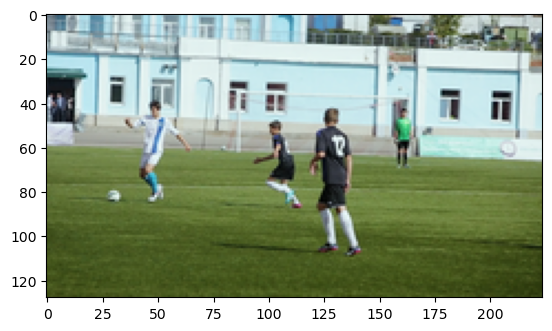

In [55]:
image_numpy = Dataset[70000][0].permute(1, 2, 0).numpy()

# Plot the image
plt.imshow(image_numpy)
# plt.axis('off')  # Hide axes for a cleaner look
plt.show()

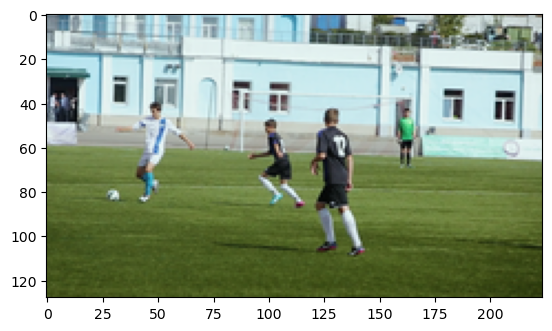

In [56]:
image_numpy = Dataset[70000][1].permute(1, 2, 0).numpy()

# Plot the image
plt.imshow(image_numpy)
# plt.axis('off')  
plt.show()

In [57]:
# print(Dataset[0][0].shape)  // 128 x 224

In [62]:
from keypoints.keypoints.ds.datasets import split

In [74]:
train_len = int(len(Dataset)*0.98)
test_len = len(Dataset) - train_len
train_t,test_t = split(Dataset,train_len,test_len)

In [75]:
print(len(train_t),train_len)

71729 71729


In [76]:
print(len(test_t),test_len)

1464 1464


In [38]:
trip_train = DataLoader(train_t, batch_size = args.batch_size, shuffle=True, drop_last=True, pin_memory=pin_memory)
trip_test = DataLoader(test_t, batch_size = args.batch_size, shuffle=True, drop_last=True, pin_memory=pin_memory)

In [39]:
len(trip_train),len(trip_test)

(4117, 457)

In [43]:
print(os.getcwd())

/home/jovyan/video-storage/amit_files/MTP_01


In [24]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Add the parent directory to sys.path
sys.path.append("/home/jovyan/video-storage/amit_files/image_background_remove_tool")

import torch
device = "cuda" if torch.cuda.is_available else "cpu"

In [5]:
from carvekit.ml.arch.tracerb7.efficientnet import EfficientEncoderB7
from carvekit.ml.wrap.tracer_b7 import TracerUniversalB7

In [6]:
model = TracerUniversalB7()

In [7]:
model = model.to(device)

In [8]:
triplet_first_image = "/home/jovyan/video-storage/amit_files/MTP_01/Vimeo_Triplet_Folder/first_image"
img_dir = os.listdir(triplet_first_image)

In [9]:
image_dir = [os.path.join(triplet_first_image, image) for image in img_dir]

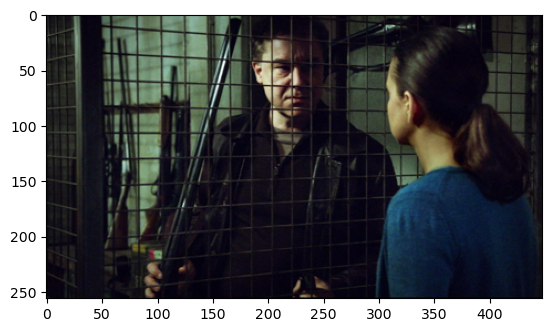

In [25]:
image = Image.open(image_dir[0])
image = np.asarray(image)
plt.imshow(image)

In [10]:
import time
len(image_dir)

73193

In [11]:
start = time.time()
output = model(image_dir[100:200])
print(time.time() - start)

/opt/conda/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


9.421136140823364


(256, 448)


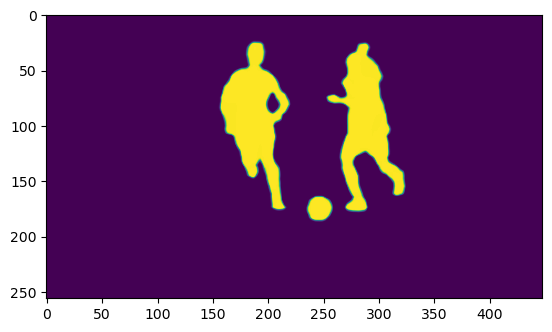

In [21]:
img = np.asarray(output[0])/255.0

# np.unique(img)
print(img.shape)
plt.imshow(img)

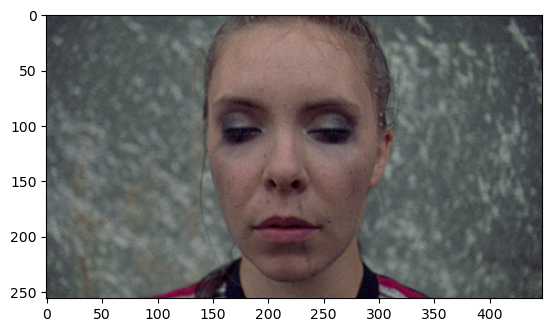

In [34]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

img = Image.open(image_dir[5])
img = np.asarray(img)
plt.imshow(img)

In [45]:
img = np.asarray(output[1])
np.unique(img)

array([0], dtype=uint8)

In [47]:
def plot_images(images, columns=3, figsize=(50, 45)):
    num_images = len(images)
    rows = (num_images + columns - 1) // columns  # Calculate number of rows needed

    fig, axes = plt.subplots(rows, columns, figsize=figsize)
    axes = axes.ravel()  # Flatten the axes array for easy iteration

    for idx, img in enumerate(images):
        # Plot image on the grid
        axes[idx].imshow(img)
        axes[idx].axis('off')  # Turn off axis

    # Turn off any remaining empty axes
    for ax in axes[num_images:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


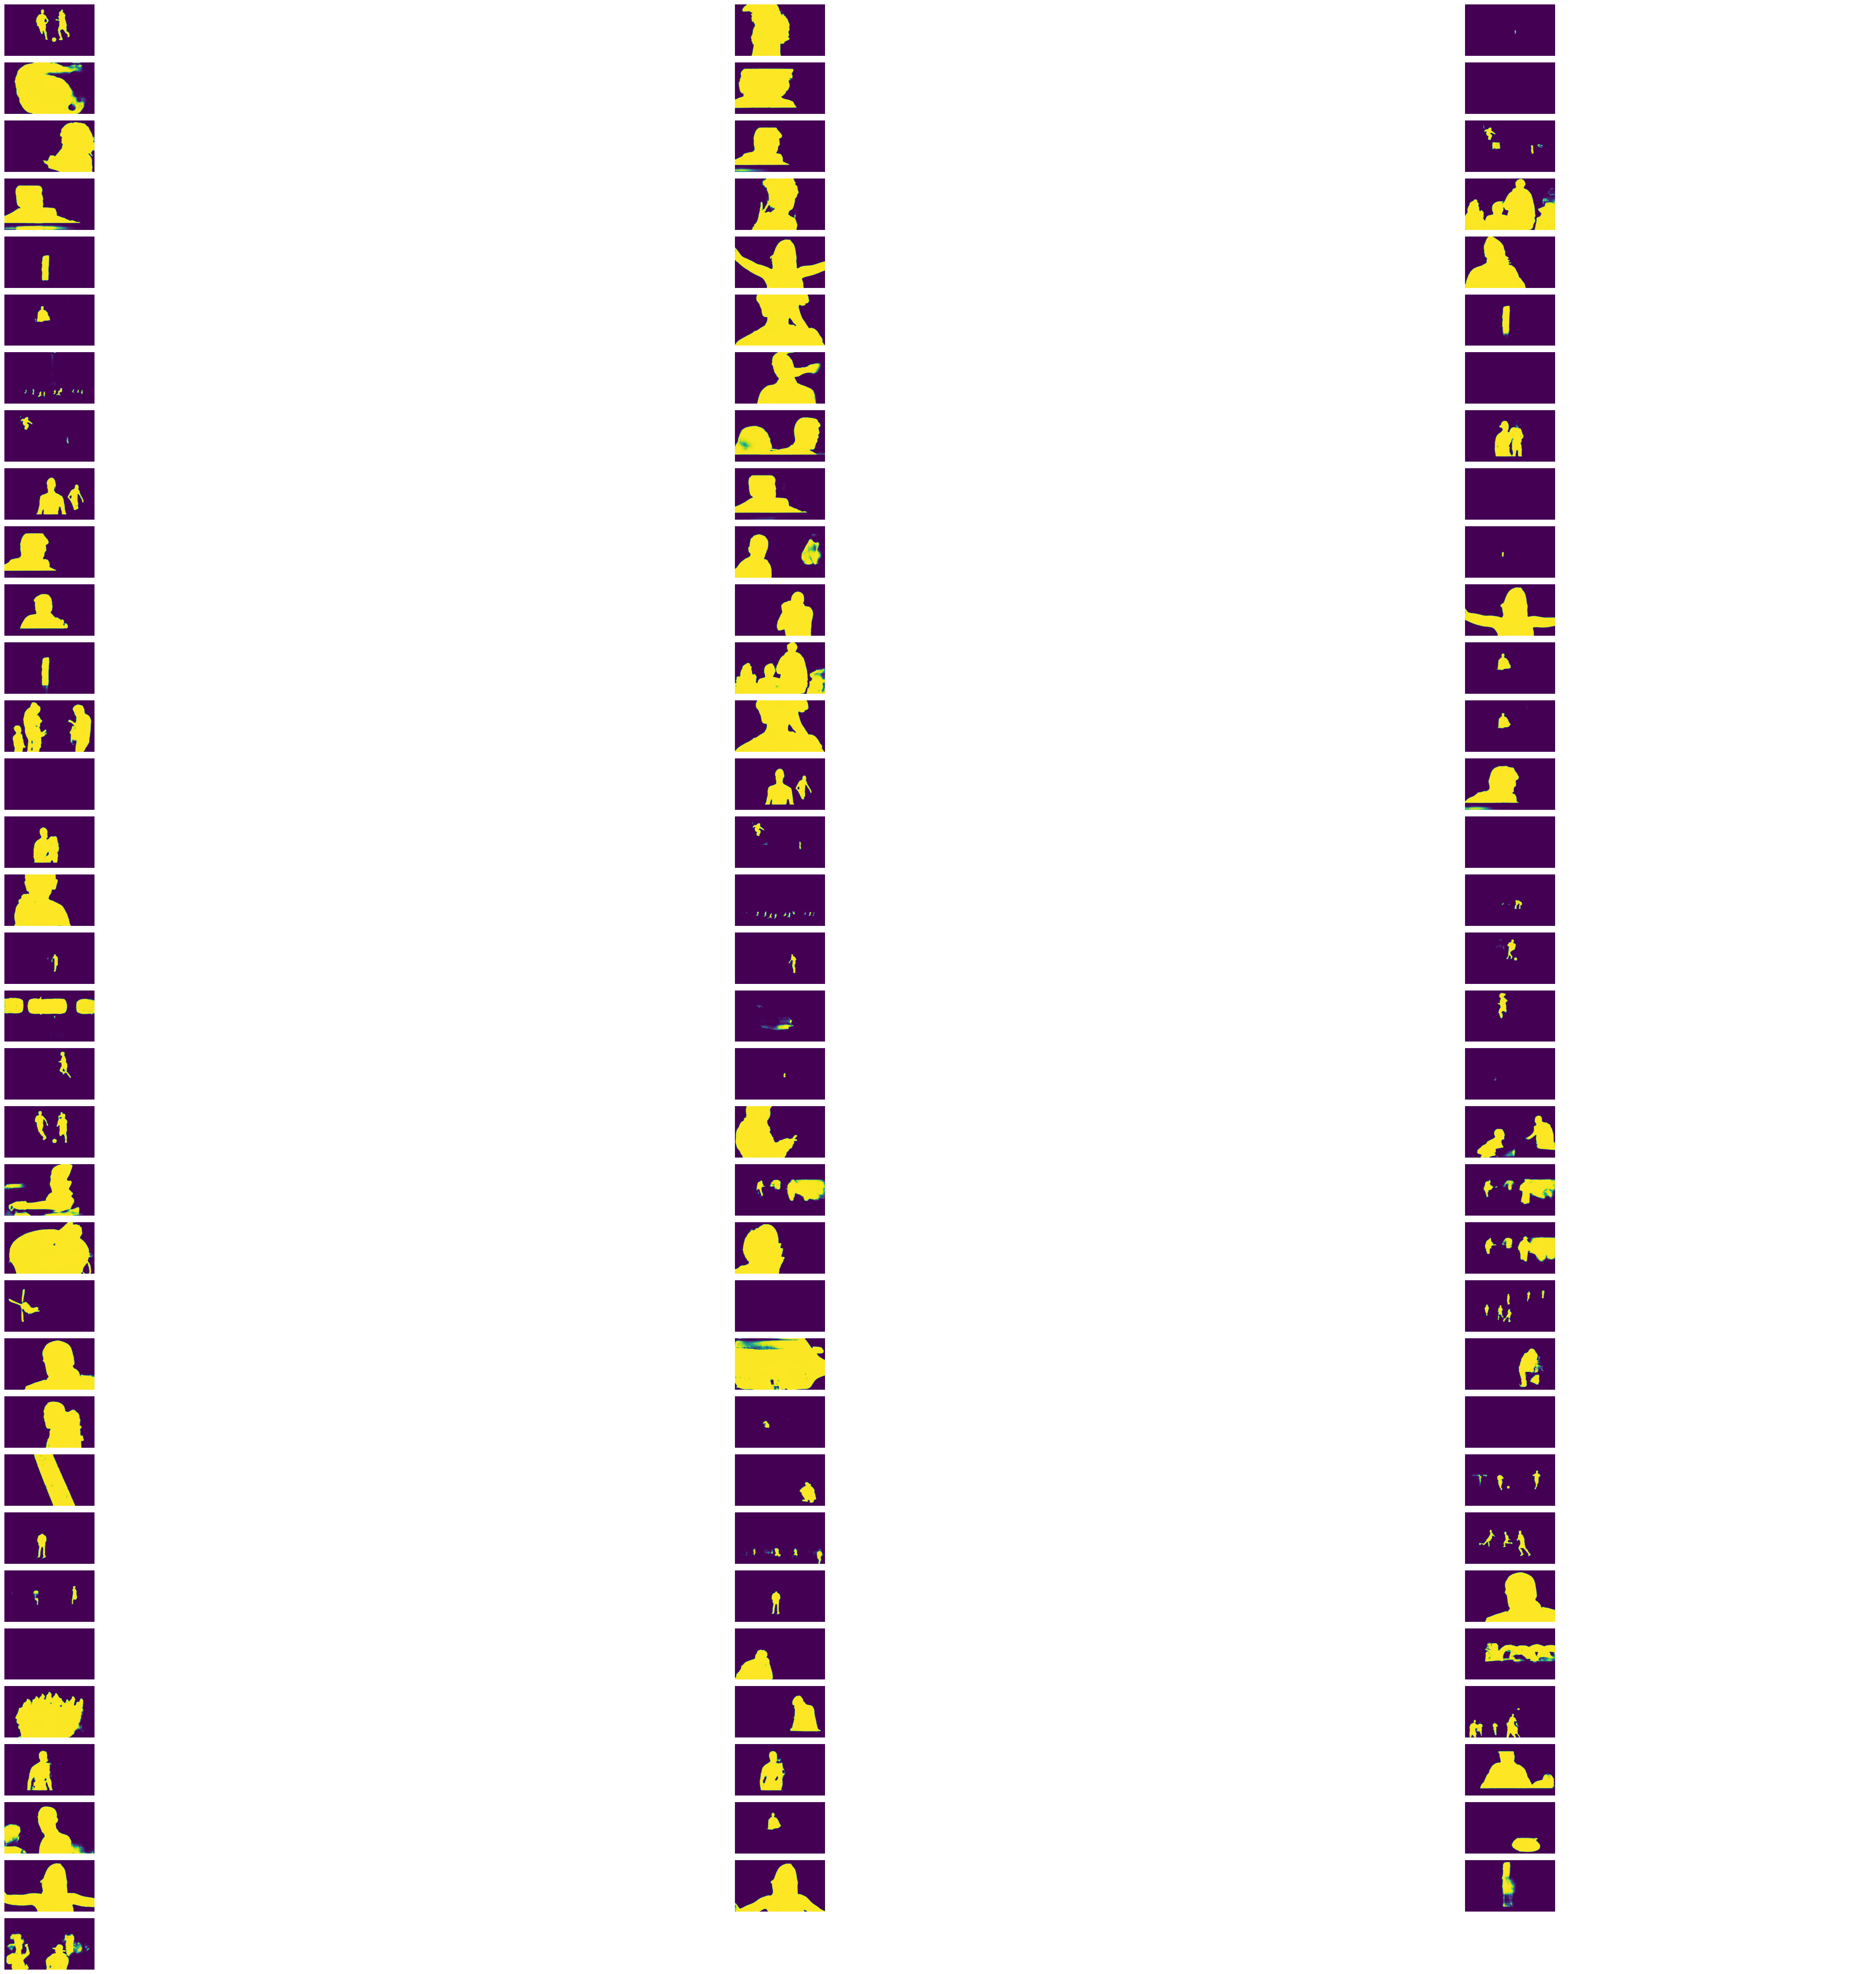

In [48]:
plot_images(output)

In [ ]:
def save_images(image_list, folder_path, img_dir):
    os.makedirs(folder_path, exist_ok=True)

    total_images = len(image_list)

    # Loop through the image list and save each image
    for i, image in enumerate(image_list):
        name = img_dir[i].split('.')[0]
        image_path = os.path.join(folder_path, f'{name}.png')
        image.save(image_path)

        # Calculate and display progress percentage
        progress = (i + 1) / total_images * 100
        print(f"Progress: {progress:.2f}%", end='\r')  # end='\r' keeps it in one line


In [ ]:
folder_path = "/home/jovyan/video-storage/amit_files/MTP_01/Vimeo_Triplet_Folder/model_output"

save_images(output, folder_path, img_dir)

# Unsupervised Keypoint Detection

In [61]:
import sys

# Add the parent directory to sys.path
sys.path.append("/home/jovyan/video-storage/amit_files/")

In [2]:
!pip install gym

In [3]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.optim import Adam
from torch.cuda.amp import autocast, GradScaler

from keypoints.keypoints.data_augments import TpsAndRotate, nop
from keypoints.keypoints.models import keynet
from keypoints.keypoints.utils import ResultsLogger
from keypoints.keypoints.ds import datasets as ds
from keypoints.keypoints.config import config

2024-10-31 05:05:02.256854: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-31 05:05:02.296057: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-31 05:05:02.898706: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
# from apex import amp

In [5]:
import yaml
import argparse
from pathlib import Path
import torch
args_path = '/home/jovyan/video-storage/amit_files/keypoints/configs/keypoints_celeba.yaml'

In [6]:
torch.cuda.set_device(0)

In [7]:
args = config(['--config', args_path,'--data_root','/home/jovyan/video-storage/amit_files/MTP_01'])
print(args)

Namespace(device=device(type='cuda', index=0), run_id=61, comment=None, demo=False, load=None, transfer_load=None, checkpoint_freq=1000, data_root='/home/jovyan/video-storage/amit_files/MTP_01', config='/home/jovyan/video-storage/amit_files/keypoints/configs/keypoints_celeba.yaml', epochs=24, processes=7, seed=None, cma_algo=None, cma_step_mode='auto', cma_step_decay=0.001, cma_initial_step_size=None, cma_samples=None, cma_oversample=0, display=False, display_freq=5000, display_kp_rows=4, opt_level='O2', model_type='F', model_in_channels=3, model_keypoints=10, transporter_combine_mode='max', policy_action_select_mode='argmax', policy_depth=1, gym_reward_count_limit=None, optimizer='Adam', batch_size=16, lr=None, dataset='celeba', dataset_train_len=190000, dataset_test_len=1100, dataset_randomize=False, data_aug_tps_cntl_pts=4, data_aug_tps_variance=0.05, data_aug_max_rotate=0.1, model_z_channels=64, data_aug_type='tps_and_rotate', **{'cma_algo;': 'fast'})


In [8]:
run_dir = f'data/models/keypoints/{args.model_type}/run_{args.run_id}'
run_dir

'data/models/keypoints/F/run_61'

In [9]:
display = ResultsLogger(run_dir=run_dir,
                            num_keypoints=args.model_keypoints,
                            title='Results',
                            visuals=args.display,
                            image_capture_freq=args.display_freq,
                            kp_rows=args.display_kp_rows,
                            comment=args.comment)
display.header(args)

device: cuda:0 run_id: 61 comment: None demo: False load: None transfer_load: None checkpoint_freq: 1000 data_root: /home/jovyan/video-storage/amit_files/MTP_01 config: /home/jovyan/video-storage/amit_files/keypoints/configs/keypoints_celeba.yaml epochs: 24 processes: 7 seed: None cma_algo: None cma_step_mode: auto cma_step_decay: 0.001 cma_initial_step_size: None cma_samples: None cma_oversample: 0 display: False display_freq: 5000 display_kp_rows: 4 opt_level: O2 model_type: F model_in_channels: 3 model_keypoints: 10 transporter_combine_mode: max policy_action_select_mode: argmax policy_depth: 1 gym_reward_count_limit: None optimizer: Adam batch_size: 16 lr: None dataset: celeba dataset_train_len: 190000 dataset_test_len: 1100 dataset_randomize: False data_aug_tps_cntl_pts: 4 data_aug_tps_variance: 0.05 data_aug_max_rotate: 0.1 model_z_channels: 64 data_aug_type: tps_and_rotate cma_algo;: fast 


In [10]:
# Selecting the args.dataset type of dataset and here "CELEBA" and celeba transform which basically includes resizing it to 128 x 128 
datapack = ds.datasets[args.dataset]
datapack

In [11]:
# Make train and test Dataset and arguments are train length, test length and path to the root directory
train, test = datapack.make(args.dataset_train_len, args.dataset_test_len, data_root=args.data_root)
print(len(train))
print(len(test))

190000
1100


In [12]:
from torch.utils.data import Subset
train = Subset(train,train.indices[0:30000])

In [13]:
pin_memory = False if args.device == 'cpu' else True
pin_memory

True

In [14]:
train_l = DataLoader(train, batch_size = args.batch_size, shuffle=True, drop_last=True, pin_memory=pin_memory)
test_l = DataLoader(test, batch_size = args.batch_size, shuffle=True, drop_last=True, pin_memory=pin_memory)

In [15]:
if args.data_aug_type == 'tps_and_rotate':
    augment = TpsAndRotate(args.data_aug_tps_cntl_pts, args.data_aug_tps_variance, args.data_aug_max_rotate)
else:
    augment = nop

In [16]:
augment

In [17]:
""" model """
kp_network = keynet.make(args).to(args.device)

In [18]:
kp_network.to(args.device)

KeyNet(
  (encoder): Unit(
    (in_block): Sequential(
      (0): ReplicationPad2d((1, 1, 1, 1))
      (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (core): Sequential(
      (0): ReplicationPad2d((1, 1, 1, 1))
      (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): ReplicationPad2d((1, 1, 1, 1))
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.01, inplace=True)
      (9): ReplicationPad2d((1, 1, 1, 1))
      (10): Conv2d(256, 256, kern

In [19]:
optim = Adam(kp_network.parameters(), lr=1e-4)

In [20]:
scaler = GradScaler()

# loss function
def l2_reconstruction_loss(x, x_, loss_mask=None):
    loss = (x - x_) ** 2
    if loss_mask is not None:
        loss = loss * loss_mask
    return torch.mean(loss)

criterion = l2_reconstruction_loss

def to_device(data, device):
    return tuple([x.to(device) for x in data])

In [21]:
print(args.epochs)

24


In [22]:
import torch
import matplotlib.pyplot as plt

def plot_all_images_channels(tensor, fig_size=(24, 16)):
    """
    Plots all channels of all images in the given 4D tensor.

    Parameters:
    tensor (torch.Tensor): The 4D tensor with shape (num_images, num_channels, height, width).
    fig_size (tuple): Size of the figure for plotting.
    """

    num_images = tensor.shape[0]
    num_channels = tensor.shape[1]
    tensor = tensor.detach().cpu().numpy()
    
    # Create a grid with 16 rows (for images) and 10 columns (for channels)
    fig, axes = plt.subplots(num_images, num_channels, figsize=fig_size)
    fig.suptitle("All Images and Their 10 Channels")

    for img_idx in range(num_images):
        for ch_idx in range(num_channels):
            ax = axes[img_idx, ch_idx]
            ax.imshow(tensor[img_idx, ch_idx], cmap='gray')  # Display each channel in grayscale
            ax.axis('off')  # Hide axes for clarity
            if img_idx == 0:
                ax.set_title(f"Channel {ch_idx+1}", fontsize=8)

    plt.tight_layout()
    plt.show()

In [23]:
import numpy as np
import matplotlib.pyplot as plt

In [41]:
for epoch in tqdm(range(1, 2)):

    if not args.demo:
            # """ training """
        batch = tqdm(trip_train, total=len(train_t) // args.batch_size)
        for i, data in enumerate(batch):
            data = to_device(data, device=args.device)
            # x, x_, loss_mask = augment(*data)
            x, x_ = data[0],data[1]
            optim.zero_grad()

            # Mixed precision forward pass
            with autocast():
                x_t, z, k, m, p, heatmap = kp_network(x,x_)
                print(heatmap.shape,x_t.shape,z.shape,k.shape,m.shape,len(p))
                # print(k)
                # loss = criterion(x_t, x_, loss_mask)
            break
        break

  0%|                                                                                             | 0/1 [00:03<?, ?it/s]

torch.Size([16, 10, 32, 56]) torch.Size([16, 3, 256, 448]) torch.Size([16, 64, 32, 56]) torch.Size([16, 10, 2]) torch.Size([16, 10, 32, 56]) 2


  0%|                                                                                | 0/1875 [00:00<?, ?it/s]/opt/conda/lib/python3.11/site-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torch/nn/functional.py:4298: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


torch.Size([16, 12, 16, 16]) torch.Size([16, 3, 128, 128]) torch.Size([16, 64, 16, 16]) torch.Size([16, 12, 2]) torch.Size([16, 12, 16, 16]) 2


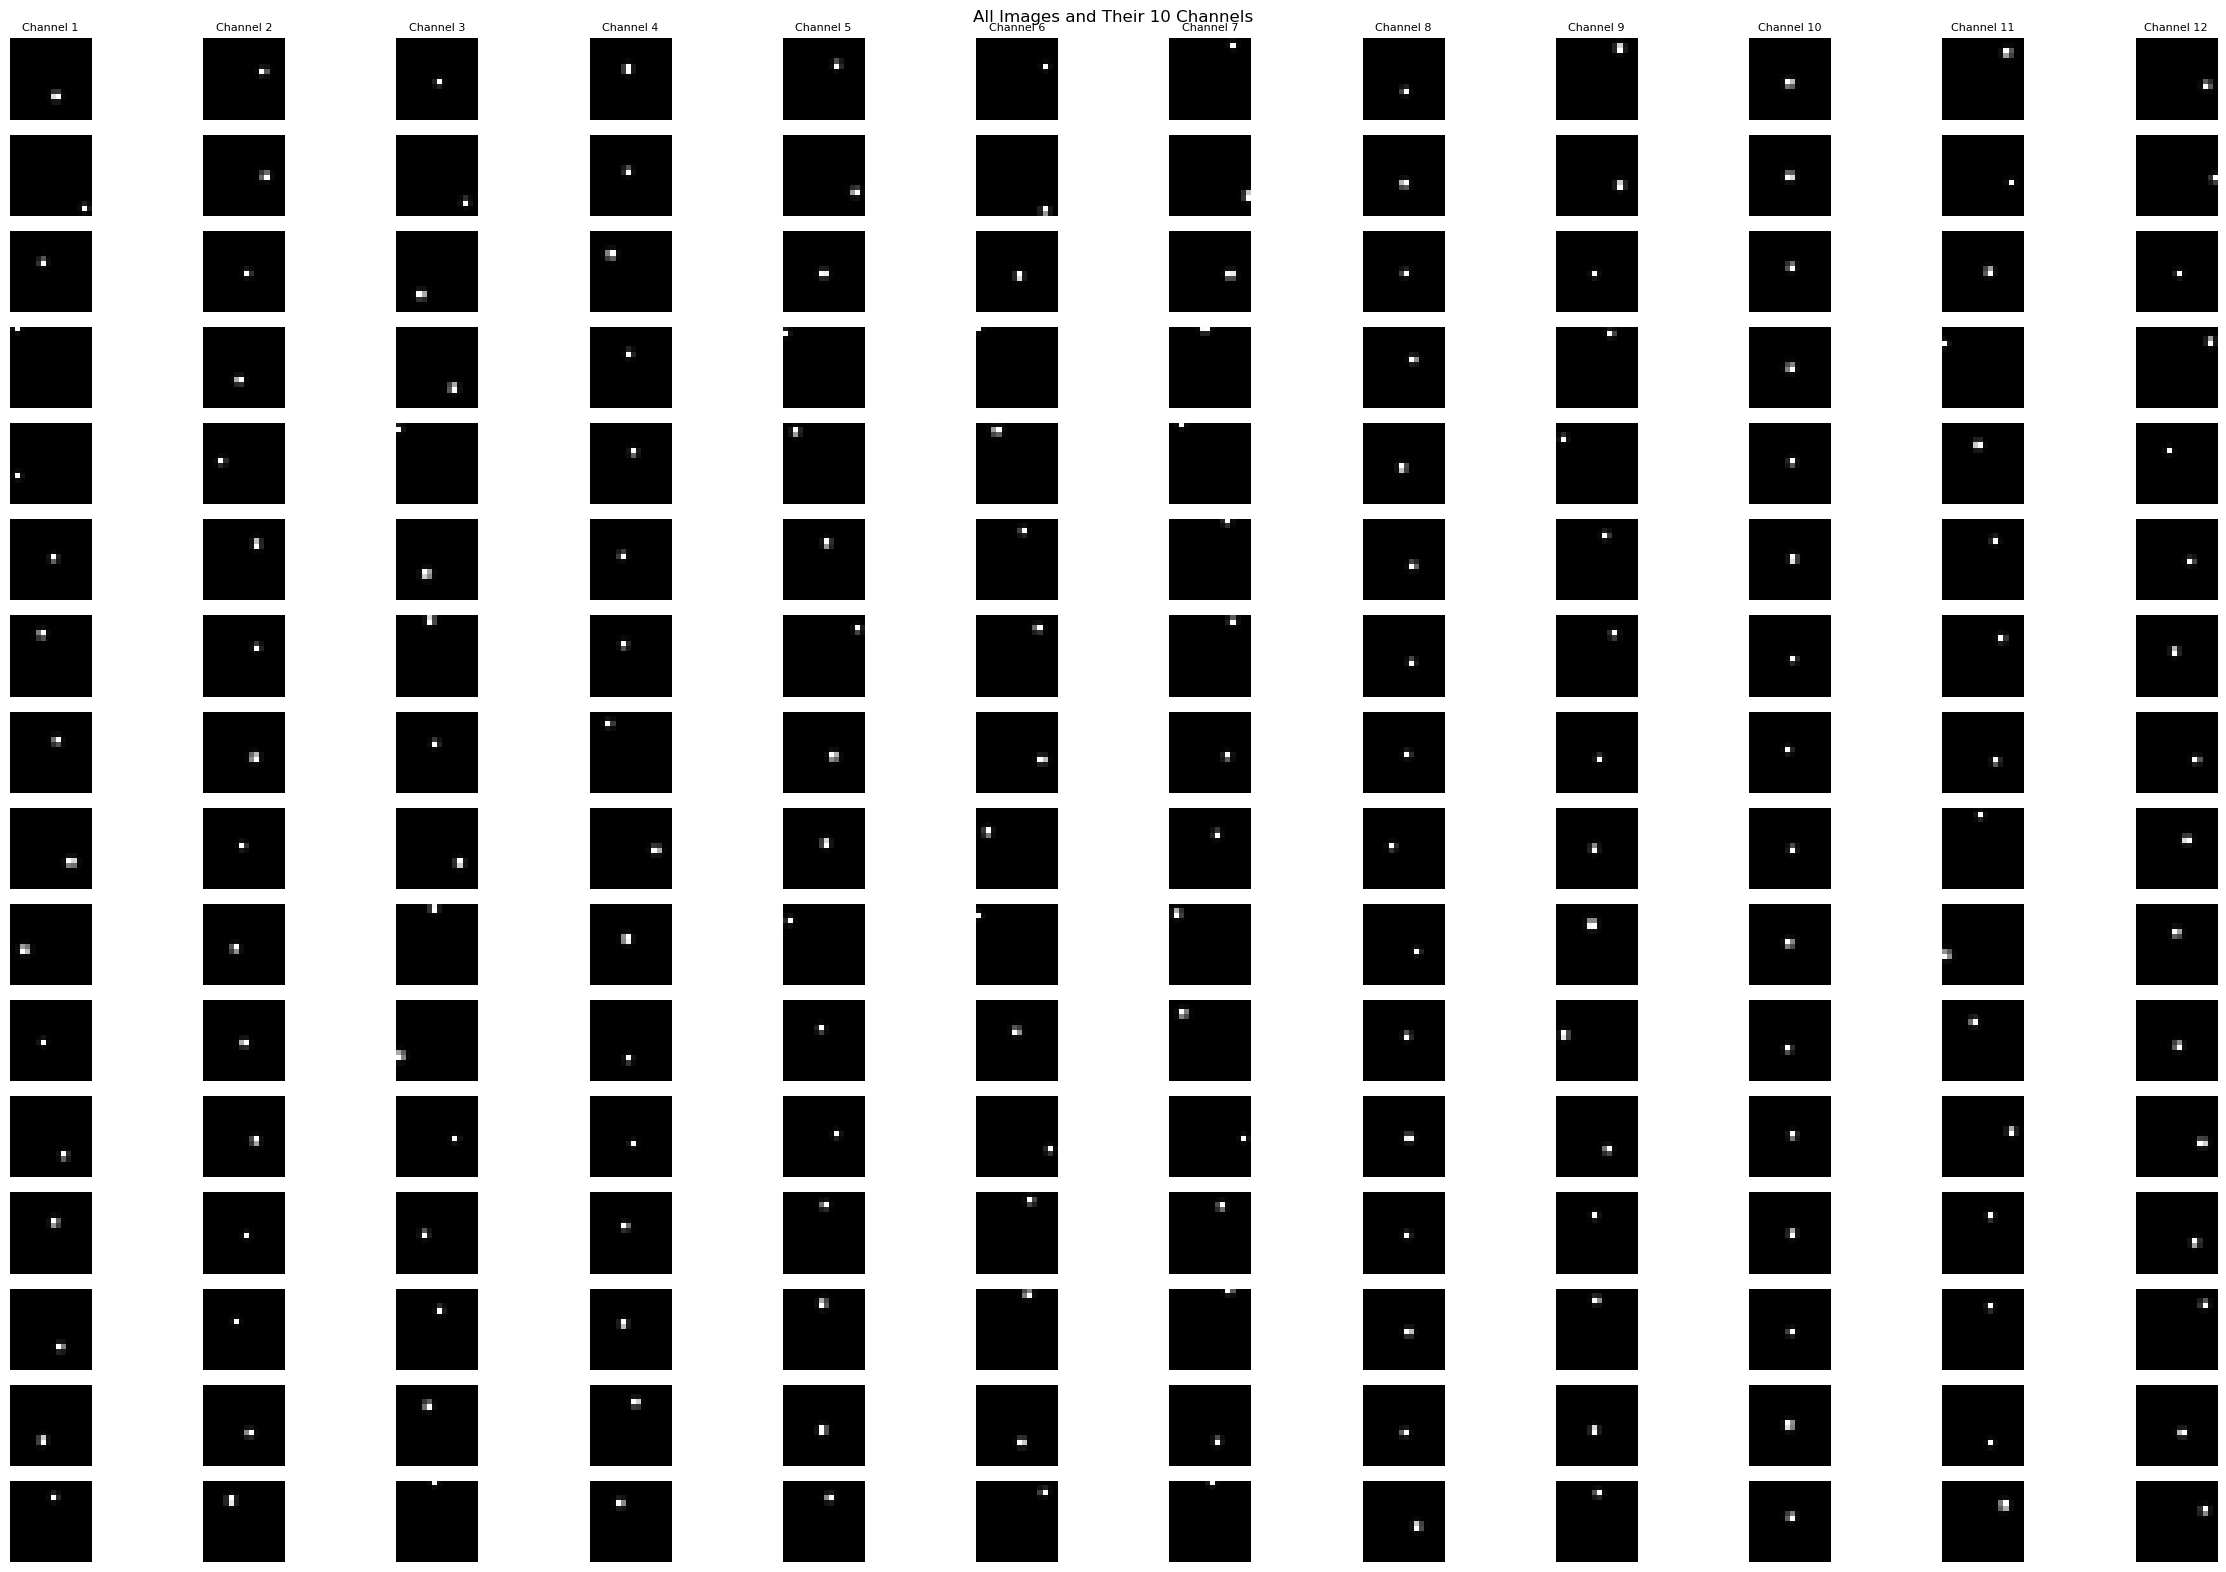

  0%|                                                                                   | 0/1 [00:19<?, ?it/s]


In [28]:
for epoch in tqdm(range(1, 2)):

    if not args.demo:
            # """ training """
        batch = tqdm(train_l, total=len(train) // args.batch_size)
        for i, data in enumerate(batch):
            data = to_device(data, device=args.device)
            x, x_, loss_mask = augment(*data)
            optim.zero_grad()

            # Mixed precision forward pass
            with autocast():
                x_t, z, k, m, p, heatmap = kp_network(x,x_)
                print(heatmap.shape,x_t.shape,z.shape,k.shape,m.shape,len(p))
                loss = criterion(x_t, x_, loss_mask)
                plot_all_images_channels(m)
            break
        break

In [ ]:
for epoch in tqdm(range(1, args.epochs + 1)):

    if not args.demo:
            # """ training """
        batch = tqdm(train_l, total=len(train) // args.batch_size)
        for i, data in enumerate(batch):
            data = to_device(data, device=args.device)
            x, x_, loss_mask = augment(*data)
            optim.zero_grad()

            # Mixed precision forward pass
            with autocast():
                x_t, z, k, m, p, heatmap = kp_network(x,x_)
                loss = criterion(x_t, x_, loss_mask)

            # Scaled backward pass
            scaler.scale(loss).backward()
            scaler.step(optim)    # Update model parameters
            scaler.update()       # Adjust the scale for next iteration

            if i % args.checkpoint_freq == 0:
                kp_network.save(run_dir + '/checkpoint')

            display.log(batch, epoch, i, loss, optim, x, x_, x_t, heatmap, k, m, p, loss_mask, type='train', depth=20)

# """ test  """
    with torch.no_grad():
        batch = tqdm(test_l, total=len(test) // args.batch_size)
        for i, data in enumerate(batch):
            data = to_device(data, device=args.device)
            x, x_, loss_mask = augment(*data)

            with autocast():
                x_t, z, k, m, p, heatmap = kp_network(x,x_)
                loss = criterion(x_t, x_, loss_mask)

            display.log(batch, epoch, i, loss, optim, x, x_, x_t, heatmap, k, m, p, loss_mask, type='test', depth=20)

        ave_loss, best_loss = display.end_epoch(epoch, optim)

# """ save if model improved """
        if ave_loss <= best_loss and not args.demo:
            kp_network.save(run_dir + '/best')

  0%|                                                                                          | 0/1875 [00:00<?, ?it/s]/opt/conda/lib/python3.11/site-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torch/nn/functional.py:4298: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(

Epoch: 1 LR: 0.0001 train Loss: 8.828941345214844:   0%|                                       | 0/1875 [00:05<?, ?it/s]
Epoch: 1 LR: 0.0001 train Loss: 8.828941345214844:   0%|                             | 1/1875 [00:16<8:19:19, 15.99s/it]
Epoch: 1 LR: 0.0001 t

EPOCH 1 LR: 0.0001 ave loss: 0.027499838080257178 best loss: 0.027499838080257178 


  0%|                                                                                          | 0/1875 [00:00<?, ?it/s]
Epoch: 2 LR: 0.0001 train Loss: 0.027114249113947154:   0%|                                    | 0/1875 [00:01<?, ?it/s]
Epoch: 2 LR: 0.0001 train Loss: 0.027114249113947154:   0%|                          | 1/1875 [00:13<7:06:14, 13.65s/it]
Epoch: 2 LR: 0.0001 train Loss: 0.026992487255483866:   0%|                          | 1/1875 [00:15<7:06:14, 13.65s/it]
Epoch: 2 LR: 0.0001 train Loss: 0.026992487255483866:   0%|                          | 2/1875 [00:15<3:34:33,  6.87s/it]
Epoch: 2 LR: 0.0001 train Loss: 0.026921746786683798:   0%|                          | 2/1875 [00:17<3:34:33,  6.87s/it]
Epoch: 2 LR: 0.0001 train Loss: 0.026921746786683798:   0%|                          | 3/1875 [00:17<2:15:54,  4.36s/it]
Epoch: 2 LR: 0.0001 train Loss: 0.026916749123483897:   0%|                          | 3/1875 [00:18<2:15:54,  4.36s/it]
Epoch: 2 LR: 0.0001 train Loss: 

In [19]:
# """ apex mixed precision """
# if args.device != 'cpu':
#     model, optimizer = amp.initialize(kp_network, optim, opt_level=args.opt_level)

In [ ]:
# if __name__ == '__main__':
    
#     args = config(['--config', args_path,'--data_root','/home/jovyan/video-storage/amit_files/MTP_01'])
#     torch.cuda.set_device(0)
#     run_dir = f'data/models/keypoints/{args.model_type}/run_{args.run_id}'

#     """ logging """
#     display = ResultsLogger(run_dir=run_dir,
#                             num_keypoints=args.model_keypoints,
#                             title='Results',
#                             visuals=args.display,
#                             image_capture_freq=args.display_freq,
#                             kp_rows=args.display_kp_rows,
#                             comment=args.comment)
#     display.header(args)

#     """ dataset """
#     datapack = ds.datasets[args.dataset]
#     train, test = datapack.make(args.dataset_train_len, args.dataset_test_len, data_root=args.data_root)
#     pin_memory = False if args.device == 'cpu' else True
#     train_l = DataLoader(train, batch_size=args.batch_size, shuffle=True, drop_last=True, pin_memory=pin_memory)
#     test_l = DataLoader(test, batch_size=args.batch_size, shuffle=True, drop_last=True, pin_memory=pin_memory)

#     """ data augmentation """
#     if args.data_aug_type == 'tps_and_rotate':
#         augment = TpsAndRotate(args.data_aug_tps_cntl_pts, args.data_aug_tps_variance, args.data_aug_max_rotate)
#     else:
#         augment = nop

#     """ model """
#     kp_network = keynet.make(args).to(args.device)

#     """ optimizer """
#     optim = Adam(kp_network.parameters(), lr=1e-4)

#     """ Initialize Gradient Scaler for Mixed Precision """
#     scaler = GradScaler()

#     """ loss function """
#     def l2_reconstruction_loss(x, x_, loss_mask=None):
#         loss = (x - x_) ** 2
#         if loss_mask is not None:
#             loss = loss * loss_mask
#         return torch.mean(loss)

#     criterion = l2_reconstruction_loss

#     def to_device(data, device):
#         return tuple([x.to(device) for x in data])

#     for epoch in tqdm(range(1, args.epochs + 1)):

#         if not args.demo:
#             """ training """
#             batch = tqdm(train_l, total=len(train) // args.batch_size)
#             for i, data in enumerate(batch):
#                 data = to_device(data, device=args.device)
#                 x, x_, loss_mask = augment(*data)

#                 optim.zero_grad()

#                 # Mixed precision forward pass
#                 with autocast():
#                     x_t, z, k, m, p, heatmap = kp_network(x,x_)
#                     loss = criterion(x_t, x_, loss_mask)

#                 # Scaled backward pass
#                 scaler.scale(loss).backward()
#                 scaler.step(optim)    # Update model parameters
#                 scaler.update()       # Adjust the scale for next iteration

#                 if i % args.checkpoint_freq == 0:
#                     kp_network.save(run_dir + '/checkpoint')

#                 display.log(batch, epoch, i, loss, optim, x, x_, x_t, heatmap, k, m, p, loss_mask, type='train', depth=20)

#         """ test  """
#         with torch.no_grad():
#             batch = tqdm(test_l, total=len(test) // args.batch_size)
#             for i, data in enumerate(batch):
#                 data = to_device(data, device=args.device)
#                 x, x_, loss_mask = augment(*data)

#                 with autocast():
#                     x_t, z, k, m, p, heatmap = kp_network(x,x_)
#                     loss = criterion(x_t, x_, loss_mask)

#                 display.log(batch, epoch, i, loss, optim, x, x_, x_t, heatmap, k, m, p, loss_mask, type='test', depth=20)

#             ave_loss, best_loss = display.end_epoch(epoch, optim)

#             """ save if model improved """
#             if ave_loss <= best_loss and not args.demo:
#                 kp_network.save(run_dir + '/best')


In [51]:
# if __name__ == '__main__':

#     args = config(['--config', args_path,'--device','cuda'])
#     torch.cuda.set_device(0)
#     run_dir = f'data/models/keypoints/{args.model_type}/run_{args.run_id}'

#     """ logging """
#     display = ResultsLogger(run_dir=run_dir,
#                             num_keypoints=args.model_keypoints,
#                             title='Results',
#                             visuals=args.display,
#                             image_capture_freq=args.display_freq,
#                             kp_rows=args.display_kp_rows,
#                             comment=args.comment)
#     display.header(args)

#     """ dataset """
#     datapack = ds.datasets[args.dataset]
#     train, test = datapack.make(args.dataset_train_len, args.dataset_test_len, data_root=args.data_root)
#     pin_memory = False if args.device == 'cpu' else True
#     train_l = DataLoader(train, batch_size=args.batch_size, shuffle=True, drop_last=True, pin_memory=pin_memory)
#     test_l = DataLoader(test, batch_size=args.batch_size, shuffle=True, drop_last=True, pin_memory=pin_memory)

#     """ data augmentation """
#     if args.data_aug_type == 'tps_and_rotate':
#         augment = TpsAndRotate(args.data_aug_tps_cntl_pts, args.data_aug_tps_variance, args.data_aug_max_rotate)
#     else:
#         augment = nop

#     """ model """
#     kp_network = keynet.make(args).to(args.device)

#     """ optimizer """
#     optim = Adam(kp_network.parameters(), lr=1e-4)

#     """ apex mixed precision """
#     if args.device != 'cpu':
#         model, optimizer = amp.initialize(kp_network, optim, opt_level=args.opt_level)

#     """ loss function """
#     def l2_reconstruction_loss(x, x_, loss_mask=None):
#         loss = (x - x_) ** 2
#         if loss_mask is not None:
#             loss = loss * loss_mask
#         return torch.mean(loss)

#     criterion = l2_reconstruction_loss

#     def to_device(data, device):
#         return tuple([x.to(device) for x in data])

#     for epoch in range(1, args.epochs + 1):

#         if not args.demo:
#             """ training """
#             batch = tqdm(train_l, total=len(train) // args.batch_size)
#             for i, data in enumerate(batch):
#                 data = to_device(data, device=args.device)
#                 x, x_, loss_mask = augment(*data)

#                 optim.zero_grad()
#                 x_t, z, k, m, p, heatmap = kp_network(x, x_)

#                 loss = criterion(x_t, x_, loss_mask)

#                 if args.device != 'cpu':
#                     with amp.scale_loss(loss, optim) as scaled_loss:
#                         scaled_loss.backward()
#                 else:
#                     loss.backward()
#                 optim.step()

#                 if i % args.checkpoint_freq == 0:
#                     kp_network.save(run_dir + '/checkpoint')

#                 display.log(batch, epoch, i, loss, optim, x, x_, x_t, heatmap, k, m, p, loss_mask, type='train', depth=20)

#         """ test  """
#         with torch.no_grad():
#             batch = tqdm(test_l, total=len(test) // args.batch_size)
#             for i, data in enumerate(batch):
#                 data = to_device(data, device=args.device)
#                 x, x_, loss_mask = augment(*data)

#                 x_t, z, k, m, p, heatmap = kp_network(x, x_)
#                 loss = criterion(x_t, x_, loss_mask)

#                 display.log(batch, epoch, i, loss, optim, x, x_, x_t, heatmap, k, m, p, loss_mask, type='test', depth=20)

#             ave_loss, best_loss = display.end_epoch(epoch, optim)

#             """ save if model improved """
#             if ave_loss <= best_loss and not args.demo:
#                 kp_network.save(run_dir + '/best')


device: cuda run_id: 13 comment: None demo: False load: None transfer_load: None checkpoint_freq: 1000 data_root: data config: /home/jovyan/video-storage/amit_files/keypoints/configs/keypoints_celeba.yaml epochs: 24 processes: 7 seed: None cma_algo: None cma_step_mode: auto cma_step_decay: 0.001 cma_initial_step_size: None cma_samples: None cma_oversample: 0 display: False display_freq: 5000 display_kp_rows: 4 opt_level: O2 model_type: F model_in_channels: 3 model_keypoints: 10 transporter_combine_mode: max policy_action_select_mode: argmax policy_depth: 1 gym_reward_count_limit: None optimizer: Adam batch_size: 16 lr: None dataset: celeba dataset_train_len: 190000 dataset_test_len: 1100 dataset_randomize: False data_aug_tps_cntl_pts: 4 data_aug_tps_variance: 0.05 data_aug_max_rotate: 0.1 model_z_channels: 64 data_aug_type: tps_and_rotate cma_algo;: fast 


FileNotFoundError: [Errno 2] No such file or directory: 'data/celeba-low'

# Keynet.py

In [25]:
import torch
import torch.nn as nn
from keypoints.keypoints.models import vgg
from keypoints.keypoints.models import knn


class KeyNet(knn.Container):
    def __init__(self, encoder,
                 keypoint, key2map,
                 decoder,
                 init_weights=True):
        super().__init__()
        self.encoder = encoder
        self.keypoint = keypoint
        self.ssm = knn.SpatialLogSoftmax()
        self.key2map = key2map
        self.decoder = decoder

        if init_weights:
            self._initialize_weights()

    def forward(self, x, x_t):

        z = self.encoder(x)

        heatmap = self.keypoint(x_t)
        k, p = self.ssm(heatmap, probs=True)
        m = self.key2map(k, height=z.size(2), width=z.size(3))

        x_t = self.decoder(torch.cat((z, m), dim=1))

        return x_t, z, k, m, p, heatmap

    def load(self, directory):
        self.encoder.load(directory + '/encoder')
        self.keypoint.load(directory + '/keypoint')
        self.decoder.load(directory + '/decoder')

    def load_from_autoencoder(self, directory):
        self._initialize_weights()
        self.encoder.load(directory + '/encoder', out_block=False)
        self.keypoint.load(directory + '/encoder', in_block=True, core=True, out_block=False)
        self.decoder.load(directory + '/decoder', in_block=False, core=True, out_block=True)

    def save(self, directory):
        self.encoder.save(directory + '/encoder')
        self.keypoint.save(directory + '/keypoint')
        self.decoder.save(directory + '/decoder')


def make(args):
    nonlinearity, kwargs = nn.LeakyReLU, {"inplace": True}
    encoder_core = vgg.make_layers(vgg.vgg_cfg[args.model_type], nonlinearity=nonlinearity, nonlinearity_kwargs=kwargs)
    encoder = knn.Unit(args.model_in_channels, args.model_z_channels, encoder_core)
    decoder_core = vgg.make_layers(vgg.decoder_cfg[args.model_type])
    decoder = knn.Unit(args.model_z_channels + args.model_keypoints, args.model_in_channels, decoder_core)
    keypoint_core = vgg.make_layers(vgg.vgg_cfg[args.model_type], nonlinearity=nonlinearity, nonlinearity_kwargs=kwargs)
    keypoint = knn.Unit(args.model_in_channels, args.model_keypoints, keypoint_core)
    keymapper = knn.GaussianLike(sigma=0.1)
    kp_network = KeyNet(encoder, keypoint, keymapper, decoder, init_weights=True)

    if args.load is not None:
        kp_network.load(args.load)
    if args.transfer_load is not None:
        kp_network.load_from_autoencoder(args.transfer_load)

    return kp_network

In [27]:
x = make(args).to(args.device)

In [28]:
x

KeyNet(
  (encoder): Unit(
    (in_block): Sequential(
      (0): ReplicationPad2d((1, 1, 1, 1))
      (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (core): Sequential(
      (0): ReplicationPad2d((1, 1, 1, 1))
      (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): ReplicationPad2d((1, 1, 1, 1))
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.01, inplace=True)
      (9): ReplicationPad2d((1, 1, 1, 1))
      (10): Conv2d(256, 256, kern

# Experiments and Plot keypoints on the images

In [26]:
import torch
import torch.nn as nn
from keypoints.keypoints.models import vgg
from keypoints.keypoints.models import knn

In [27]:
nonlinearity, kwargs = nn.LeakyReLU, {"inplace": True}
encoder_core = vgg.make_layers(vgg.vgg_cfg[args.model_type], nonlinearity = nonlinearity, nonlinearity_kwargs = kwargs)
encoder = knn.Unit(args.model_in_channels, args.model_z_channels, encoder_core)
    

In [28]:
decoder_core = vgg.make_layers(vgg.decoder_cfg[args.model_type])
decoder = knn.Unit(args.model_z_channels + args.model_keypoints, args.model_in_channels, decoder_core)


In [29]:
keypoint_core = vgg.make_layers(vgg.vgg_cfg[args.model_type], nonlinearity = nonlinearity, nonlinearity_kwargs = kwargs)
keypoint = knn.Unit(args.model_in_channels, args.model_keypoints, keypoint_core)

In [38]:
keypoint.out_block.load_state_dict(torch.load('/home/jovyan/video-storage/amit_files/MTP_01/data/models/keypoints/F/run_51/best/keypoint/out_block.mdl'))

<All keys matched successfully>

In [41]:
# Access the state dict to view weights
state_dict = keypoint.out_block.state_dict()

# Print the weights of each layer
for layer_name, weights in state_dict.items():
    print(f"Layer: {layer_name}")
    print(weights.shape)
    print()  # New line for better readability

Layer: 0.weight
torch.Size([10, 512, 1, 1])

Layer: 0.bias
torch.Size([10])



In [23]:
kp_network

KeyNet(
  (encoder): Unit(
    (in_block): Sequential(
      (0): ReplicationPad2d((1, 1, 1, 1))
      (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (core): Sequential(
      (0): ReplicationPad2d((1, 1, 1, 1))
      (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): ReplicationPad2d((1, 1, 1, 1))
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.01, inplace=True)
      (9): ReplicationPad2d((1, 1, 1, 1))
      (10): Conv2d(256, 256, kern

In [24]:
kp_network.encoder.in_block.load_state_dict(torch.load('/home/jovyan/video-storage/amit_files/MTP_01/data/models/keypoints/F/run_51/best/encoder/in_block.mdl'))
kp_network.encoder.core.load_state_dict(torch.load('/home/jovyan/video-storage/amit_files/MTP_01/data/models/keypoints/F/run_51/best/encoder/core.mdl'))
kp_network.encoder.out_block.load_state_dict(torch.load('/home/jovyan/video-storage/amit_files/MTP_01/data/models/keypoints/F/run_51/best/encoder/out_block.mdl'))

kp_network.keypoint.in_block.load_state_dict(torch.load('/home/jovyan/video-storage/amit_files/MTP_01/data/models/keypoints/F/run_51/best/keypoint/in_block.mdl'))
kp_network.keypoint.core.load_state_dict(torch.load('/home/jovyan/video-storage/amit_files/MTP_01/data/models/keypoints/F/run_51/best/keypoint/core.mdl'))
kp_network.keypoint.out_block.load_state_dict(torch.load('/home/jovyan/video-storage/amit_files/MTP_01/data/models/keypoints/F/run_51/best/keypoint/out_block.mdl'))

kp_network.decoder.in_block.load_state_dict(torch.load('/home/jovyan/video-storage/amit_files/MTP_01/data/models/keypoints/F/run_51/best/decoder/in_block.mdl'))
kp_network.decoder.core.load_state_dict(torch.load('/home/jovyan/video-storage/amit_files/MTP_01/data/models/keypoints/F/run_51/best/decoder/core.mdl'))
kp_network.decoder.out_block.load_state_dict(torch.load('/home/jovyan/video-storage/amit_files/MTP_01/data/models/keypoints/F/run_51/best/decoder/out_block.mdl'))

<All keys matched successfully>

In [25]:
kp_network.eval()

KeyNet(
  (encoder): Unit(
    (in_block): Sequential(
      (0): ReplicationPad2d((1, 1, 1, 1))
      (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (core): Sequential(
      (0): ReplicationPad2d((1, 1, 1, 1))
      (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): ReplicationPad2d((1, 1, 1, 1))
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.01, inplace=True)
      (9): ReplicationPad2d((1, 1, 1, 1))
      (10): Conv2d(256, 256, kern

In [50]:
import torch
import numpy as np
import cv2
from PIL import Image
import torchvision.transforms as transforms

# Assuming color_map function is defined like this:
def color_map(num_colors=20):
    # Generate a color map with 'num_colors' unique colors
    return np.random.randint(0, 255, size=(num_colors, 3))

def plot_keypoints_on_image(k, image_tensor, radius=3, thickness=2):
    # Ensure single image and keypoints are provided, not a batch
    if len(k.shape) != 2:
        raise ValueError('Expected keypoints for a single image, not a batch.')

    # Extract image dimensions
    height, width = image_tensor.size(1), image_tensor.size(2)
    num_keypoints = k.size(0)

    # Scale keypoints from normalized to pixel coordinates
    k = k.clone()  # Clone to avoid modifying the original tensor
    k[:, 0] = k[:, 0] * height  # Scale y-coordinate
    k[:, 1] = k[:, 1] * width   # Scale x-coordinate
    k.floor_()                  # Round down to the nearest integer
    k = k.detach().cpu().numpy()  # Convert to NumPy for OpenCV

    # Convert the image tensor to a PIL image, then to a NumPy array
    img = transforms.ToPILImage()(image_tensor.cpu())
    img = np.array(img)

    # Generate color map and plot each keypoint
    cm = color_map(num_keypoints)  # Create color map for each keypoint
    for co_ord, color in zip(k, cm):
        color = tuple(color.astype(int).tolist())  # Convert to tuple of int RGB values
        co_ord = co_ord.squeeze().astype(int)      # Ensure coordinates are integers
        cv2.circle(img, (co_ord[1], co_ord[0]), radius, color, thickness)

    return img


In [51]:
def plot_corresponding_images(tensor1, tensor2, tensor3,k):
    """
    Plots corresponding images from three tensors in a 16-row grid with 3 columns.
    
    Parameters:
    - tensor1 (torch.Tensor): First tensor of shape (16, 3, 16, 16).
    - tensor2 (torch.Tensor): Second tensor of shape (16, 3, 16, 16).
    - tensor3 (torch.Tensor): Third tensor of shape (16, 3, 16, 16).
    """
    # np.transpose(array, (1, 0, 2))
    tensor1 = tensor1.detach().cpu().numpy()
    tensor2 = tensor2.detach().cpu().numpy()

    images = []
    for i in range(0,k.shape[0]):
        img = plot_keypoints_on_image(k[i],tensor3[i])
        images.append(img)

    tensor3 = np.asarray(images)
    
    batch_size = tensor1.shape[0]  # Expected to be 16
    num_cols = 3  # Since we have 3 tensors
    num_rows = batch_size  # Each row will represent one set of corresponding images

    # Set up the figure and axis grid
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))
    fig.suptitle("Corresponding Images from Three Tensors", fontsize=16)

    # Loop through each batch item and plot the corresponding images
    for i in range(batch_size):
        # Tensor 1 image
        image1 = np.transpose(tensor1[i], (1, 2, 0))  # (3, 16, 16) -> (16, 16, 3)
        axes[i, 0].imshow(image1)
        axes[i, 0].axis("off")
        axes[i, 0].set_title(f"Tensor 1 - Image {i+1}")

        # Tensor 2 image
        image2 = np.transpose(tensor2[i], (1, 2, 0))
        axes[i, 1].imshow(image2)
        axes[i, 1].axis("off")
        axes[i, 1].set_title(f"Tensor 2 - Image {i+1}")

        # Tensor 3 image
        image3 = tensor3[i]
        axes[i, 2].imshow(image3)
        axes[i, 2].axis("off")
        axes[i, 2].set_title(f"Tensor 3 - Image {i+1}")

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Adjust to make room for title
    plt.show()

In [52]:
import matplotlib.pyplot as plt
import torch

def plot_tensor_images(tensor):
    # Ensure the tensor has the expected shape
    assert tensor.shape[1] == 3, "Expected 3 channels for RGB images"
    tensor = tensor.detach().cpu().numpy()

    # Convert tensor to numpy
    images = np.transpose(tensor, (0, 2, 3, 1))  # Shape (16, 16, 16, 3)

    # Plot the images in a 4x4 grid
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        img = images[i]
        ax.imshow(img)
        ax.axis('off')
    plt.show()

  0%|                                                                                            | 0/68 [00:00<?, ?it/s]

torch.Size([16, 10, 16, 16]) torch.Size([16, 3, 128, 128]) torch.Size([16, 64, 16, 16]) torch.Size([16, 10, 2]) torch.Size([16, 10, 16, 16]) 2


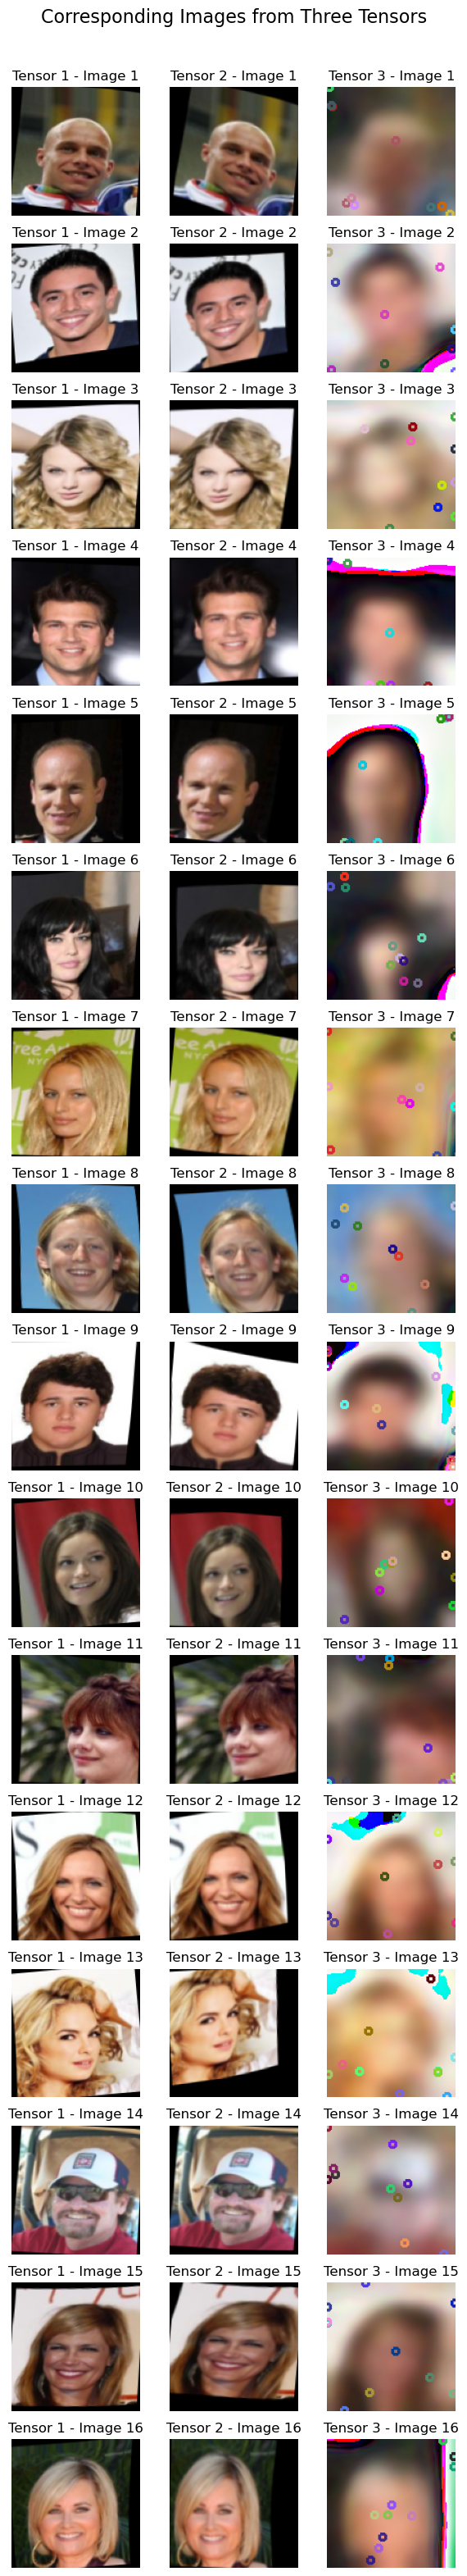

  0%|                                                                                             | 0/1 [00:04<?, ?it/s]


In [53]:
for epoch in tqdm(range(1, 2)):

# """ test  """
    with torch.no_grad():
        batch = tqdm(test_l, total=len(test) // args.batch_size)
        for i, data in enumerate(batch):
            data = to_device(data, device=args.device)
            x, x_, loss_mask = augment(*data)
            

            with autocast():
                x_t, z, k, m, p, heatmap = kp_network(x,x_)
                print(heatmap.shape,x_t.shape,z.shape,k.shape,m.shape,len(p))
                # Check the dtype of the tensor
                # print("The dtype of the tensor is:", x_t.dtype)
                # # Normalize the tensor to range [0, 1]
                # tensor_min = x_t.min()
                # tensor_max = x_t.max()
                
                # normalized_tensor = ((x_t - tensor_min) / (tensor_max - tensor_min)).float()
                plot_corresponding_images(x, x_, x_t,k)
            break        
    break

# Plot All the keypoints

In [ ]:
import torch
import matplotlib.pyplot as plt

def plot_all_images_channels(tensor, fig_size=(20, 16)):
    """
    Plots all channels of all images in the given 4D tensor.

    Parameters:
    tensor (torch.Tensor): The 4D tensor with shape (num_images, num_channels, height, width).
    fig_size (tuple): Size of the figure for plotting.
    """
    # Check tensor dimensions
    if tensor.ndim != 4 or tensor.shape[1] != 10 or tensor.shape[0] != 16:
        raise ValueError("Expected tensor of shape (16, 10, H, W)")

    num_images = tensor.shape[0]
    num_channels = tensor.shape[1]
    tensor = tensor.detach().cpu().numpy()
    # Create a grid with 16 rows (for images) and 10 columns (for channels)
    fig, axes = plt.subplots(num_images, num_channels, figsize=fig_size)
    fig.suptitle("All Images and Their 10 Channels")

    for img_idx in range(num_images):
        for ch_idx in range(num_channels):
            ax = axes[img_idx, ch_idx]
            ax.imshow(tensor[img_idx, ch_idx], cmap='gray')  # Display each channel in grayscale
            ax.axis('off')  # Hide axes for clarity
            if img_idx == 0:
                ax.set_title(f"Channel {ch_idx+1}", fontsize=8)

    plt.tight_layout()
    plt.show()

# Create .YAML File for Triplet Dataset

In [79]:
# This one is for Baseline model
import yaml

# Define the data as a dictionary
config_data = {
    'checkpoint_freq': 1000,
    'model_type': 'F',
    'model_in_channels': 3,
    'model_z_channels': 64,
    'model_keypoints': 10,
    'opt_level': 'O2',
    'dataset_1': 'first_image',
    'dataset_2': 'second_image',
    'dataset_train_len': 71729,
    'dataset_test_len': 1464,
    'dataset_randomize': False,
    'data_aug_type': None,
    'data_aug_tps_cntl_pts': 4,
    'data_aug_tps_variance': 0.05,
    'data_aug_max_rotate': 0.1,
    'batch_size': 16,
    'epochs': 24
}

# Write the data to a YAML file
with open('keypoints_triplet.yaml', 'w') as file:
    yaml.dump(config_data, file, default_flow_style=False)


In [ ]:
# This one is for normalized loss  using forground mask in loss function

In [ ]:
# # Define the data as a dictionary
# config_data = {
#     'checkpoint_freq': 1000,
#     'model_type': 'F',
#     'model_in_channels': 3,
#     'model_z_channels': 64,
#     'model_keypoints': 10,
#     'opt_level': 'O2',
#     'dataset_1': 'first_image',
#     'dataset_2': 'second_image',
#     'dataset_train_len': 71729,
#     'dataset_test_len': 1464,
#     'dataset_randomize': False,
#     'data_aug_type': None,
#     'data_aug_tps_cntl_pts': 4,
#     'data_aug_tps_variance': 0.05,
#     'data_aug_max_rotate': 0.1,
#     'batch_size': 16,
#     'epochs': 24
# }

# # Write the data to a YAML file
# with open('keypoints_triplet.yaml', 'w') as file:
#     yaml.dump(config_data, file, default_flow_style=False)
